References:

1. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py
2. https://pywavelets.readthedocs.io/en/latest/

In [1]:
import os
import sys
import torch
import argparse
import torchvision
import numpy as np
import torch.nn as nn
import scipy.io as sio
import cv2
import pywt
import pywt.data
import matplotlib.image as image

from PIL import Image
from tqdm import tqdm
from datetime import datetime
from collections import defaultdict
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from os.path import join, isdir, abspath, dirname
import matplotlib.pyplot as plt
# Customized import.
from networks import HED
from datasets import BsdsDataset
from utils import Logger, AverageMeter, \
    load_checkpoint, save_checkpoint, load_vgg16_caffe, load_pretrained_caffe


# # Parse arguments.
# parser = argparse.ArgumentParser(description='HED training.')
# # 1. Actions.
# parser.add_argument('--test',             default=False,             help='Only test the model.', action='store_true')
# # 2. Counts.
# parser.add_argument('--train_batch_size', default=1,    type=int,   metavar='N', help='Training batch size.')
# parser.add_argument('--test_batch_size',  default=1,    type=int,   metavar='N', help='Test batch size.')
# parser.add_argument('--train_iter_size',  default=10,   type=int,   metavar='N', help='Training iteration size.')
# parser.add_argument('--max_epoch',        default=40,   type=int,   metavar='N', help='Total epochs.')
# parser.add_argument('--print_freq',       default=500,  type=int,   metavar='N', help='Print frequency.')
# # 3. Optimizer settings.
# parser.add_argument('--lr',               default=1e-6, type=float, metavar='F', help='Initial learning rate.')
# parser.add_argument('--lr_stepsize',      default=1e4,  type=int,   metavar='N', help='Learning rate step size.')
# # Note: Step size is based on number of iterations, not number of batches.
# #   https://github.com/s9xie/hed/blob/94fb22f10cbfec8d84fbc0642b224022014b6bd6/src/caffe/solver.cpp#L498
# parser.add_argument('--lr_gamma',         default=0.1,  type=float, metavar='F', help='Learning rate decay (gamma).')
# parser.add_argument('--momentum',         default=0.9,  type=float, metavar='F', help='Momentum.')
# parser.add_argument('--weight_decay',     default=2e-4, type=float, metavar='F', help='Weight decay.')
# # 4. Files and folders.
# parser.add_argument('--vgg16_caffe',      default='',                help='Resume VGG-16 Caffe parameters.')
# parser.add_argument('--checkpoint',       default='',                help='Resume the checkpoint.')
# parser.add_argument('--caffe_model',      default='',                help='Resume HED Caffe model.')
# parser.add_argument('--output',           default='./output',        help='Output folder.')
# parser.add_argument('--dataset',          default='./data/HED-BSDS', help='HED-BSDS dataset folder.')
# # 5. Others.
# parser.add_argument('--cpu',              default=False,             help='Enable CPU mode.', action='store_true')
# args = parser.parse_args()

# Set device.
device = torch.device('cpu')


In [33]:
def wav_trans_grayscale(images):
    images = torchvision.utils.make_grid(images)
    npimg = images.numpy()
    img_np_right_dim = np.transpose(npimg, (1, 2, 0))
    img_np_right_dim = cv2.cvtColor(img_np_right_dim, cv2.COLOR_BGR2GRAY)
    coeffs2 = pywt.dwt2(img_np_right_dim, 'haar')
    LL, (LH, HL, HH) = coeffs2
    return([LL, LH, HL, HH])



def wav_trans(images):
    # convert to numpy
    images = images.numpy() # making images an nchw numpy array
    images = images[0,0,:,:] # making images an hw numpy array
    coeffs2 = pywt.dwt2(images, 'haar')
    LL, (LH, HL, HH) = coeffs2

    # LL is an hw numpy array

    # convert LL into a torch tensor of NCHW
    
    LL[LL>255.0] = 255.0
    height = LL.shape[0]
    width = LL.shape[1]
    LL = torch.from_numpy(LL)
    LL = torch.reshape(LL,(1, 1, height, width))
    
    return(LL)


def WT_grayscale_path_input(path):  
    """Takes as input path string"""
    orig_image = plt.imread(path)
    if(len(orig_image.shape)==3):
        gray_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = orig_image
    coeffs2 = pywt.dwt2(gray_image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    return [LL, LH, HL, HH]

def im_save_path_modifier(input_path, mode):
    """
    parameter: input_path is the path of the original image
    parameter: mode is one of LL, LH, HL, HH
    """
    dir_path = input_path[:16] + f'{mode}/' + input_path[16:input_path.rfind('/')]
    image_path = input_path[:16] + f'{mode}/' + input_path[16:]
    return(dir_path, image_path)

def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [18]:
# current_dir = abspath(dirname(__file__))
# output_dir = join(current_dir, args.output)
# if not isdir(output_dir):
#     os.makedirs(output_dir)

# # Set logger.
# now_str = datetime.now().strftime('%y%m%d-%H%M%S')
# log = Logger(join(output_dir, 'log-{}.txt'.format(now_str)))
# sys.stdout = log  # Overwrite the standard output.

################################################
# II. Datasets.
################################################
# Datasets and dataloaders.
train_dataset = BsdsDataset(dataset_dir='./data/HED-BSDS/LL', split='train')
test_dataset  = BsdsDataset(dataset_dir='./data/HED-BSDS/LL', split='test')
train_loader  = DataLoader(train_dataset, batch_size=1,
                           num_workers=4, drop_last=True, shuffle=True)
test_loader   = DataLoader(test_dataset,  batch_size=1,
                           num_workers=4, drop_last=False, shuffle=False)



In [34]:
dataiter = iter(train_loader)

In [47]:
images, labels = dataiter.next()
print(labels.shape)

torch.Size([1, 1, 209, 503])


In [48]:
mask = (labels > 0.5).float()

In [49]:
mask.shape

torch.Size([1, 1, 209, 503])

(array([[193.,   6.,   5., ...,   0.,   0.,   0.],
        [191.,   7.,   4., ...,   0.,   0.,   0.],
        [191.,   7.,   4., ...,   0.,   0.,   0.],
        ...,
        [209.,   0.,   0., ...,   0.,   0.,   0.],
        [209.,   0.,   0., ...,   0.,   0.,   0.],
        [209.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 503 Lists of Patches objects>)

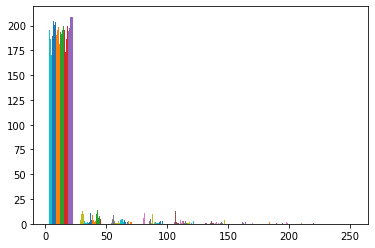

In [50]:
labels_4_hist = labels[0,0,:,:].numpy()
plt.hist(labels_4_hist)

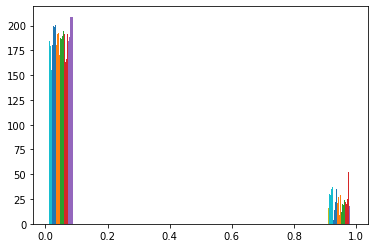

In [51]:
mask_4_hist = mask[0,0,:,:].numpy()
plt.hist(mask_4_hist);

In [52]:
wt_labels = wav_trans(labels)

(array([[ 92.,   4.,   1., ...,   1.,   1.,   0.],
        [ 93.,   1.,   3., ...,   0.,   1.,   0.],
        [ 93.,   6.,   0., ...,   0.,   1.,   1.],
        ...,
        [105.,   0.,   0., ...,   0.,   0.,   0.],
        [105.,   0.,   0., ...,   0.,   0.,   0.],
        [105.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 252 Lists of Patches objects>)

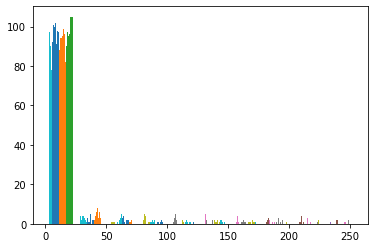

In [53]:
labels_wt_4_hist = wt_labels[0,0,:,:].numpy()
plt.hist(labels_wt_4_hist)

In [54]:
mask_wt = (wt_labels > 0.5).float()

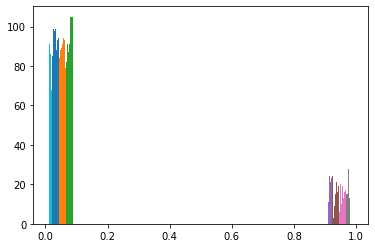

In [56]:
plt.hist(mask_wt[0,0,:,:].numpy());

In [ ]:
plt.imshow(labels[0,0,:,:].numpy())

In [ ]:
LL = wav_trans(labels)

In [ ]:
height = LL.shape[0]
width = LL.shape[1]
LL = torch.from_numpy(LL)
print(LL.shape)
LL = torch.reshape(LL,(1, 1, height, width))
print(LL.shape)

In [ ]:
train_dataset.__len__()

In [ ]:
images, labels, path, label_path = dataiter.next()

wav_trans_imlist = WT_grayscale_path_input(path[0])
wav_trans_imlist_names  = ['LL', 'LH', 'HL', 'HH']


for i in range(len(wav_trans_imlist)):
    
    # saving image
    
    dir_path, image_path = im_save_path_modifier(path[0], str(wav_trans_imlist_names[i]))
    os.makedirs(dir_path)
    plt.imsave(image_path, wav_trans_imlist[i], cmap = 'gray')
    
    # saving label
    # retrieve label image
    im_label = plt.imread(label_path[0])
    label_dir_path_new, label_path_new = im_save_path_modifier(label_path[0], str(wav_trans_imlist_names[i]))
    os.makedirs(label_dir_path_new)
    plt.imsave(label_path_new, im_label, cmap = 'gray')


In [ ]:
sad_images = []
sad_labels = []

In [ ]:
for j, data in tqdm(enumerate(train_loader, 0)):
    
    images, path = data
    
    print(path[0])

    wav_trans_imlist = WT_grayscale_path_input(path[0])
    wav_trans_imlist_names  = ['LL', 'LH', 'HL', 'HH']


    for i in range(len(wav_trans_imlist)):

        # saving image

        dir_path, image_path = im_save_path_modifier(path[0], str(wav_trans_imlist_names[i]))
        os.makedirs(dir_path, exist_ok=True)
        plt.imsave(image_path, wav_trans_imlist[i], cmap = 'gray')

        # saving label
        # retrieve label image
        im_label = plt.imread(label_path[0])
        label_dir_path_new, label_path_new = im_save_path_modifier(label_path[0], str(wav_trans_imlist_names[i]))
        os.makedirs(label_dir_path_new, exist_ok=True)
        plt.imsave(label_path_new, im_label, cmap = 'gray')
        
    if(j%1000==0):
        print(j)

In [ ]:
len(sad_labels)

Idea: Instead of taking image from the dataloader, we take the image path from it and get the image ourselves from the path. So we don't have to deal with torch tensors.

We should convert to numpy before saving images and labels.

In [ ]:
imshow(torchvision.utils.make_grid(images))

Preprocessing:  
Option 1:

1. Take wavelet transform of every channel
2. Stack up RGB channels after performing wavelet transform
3. Feed this to network.

Option 2:

1. Take grayscale of the input image
2. Pass this to network.  
Note: For option 2, we will have to change the first layer of the network to suit our changed dimensions of input.

In [ ]:
fig = plt.figure(figsize = [10,10])
ax1 = fig.add_subplot(221)
ax1.imshow(LL, cmap = 'gray')
ax1.set_title('LL')
ax2 = fig.add_subplot(222)
ax2.imshow(LH, cmap = 'gray')
ax2.set_title('LH')
ax3 = fig.add_subplot(223)
ax3.imshow(HL, cmap = 'gray')
ax3.set_title('HL')
ax4 = fig.add_subplot(224)
ax4.imshow(HH, cmap = 'gray')
ax4.set_title('HH')

1. Write a function that does this - Done!
2. Create 4 datasets
3. Train 4 networks

Step 2:

We need to:

1. Load image from path normal/p1  
2. Preprocess image
3. Save it in LL/p1, LH/p1, HL/p1, and HH/p1

1. Use os.mkdir for one image - Done!
2. Do it for every mode. - Done!
3. Do it for every image. - Pending!

#### Tasks for 11/28
1. solve np shape error
2. do it for every image

We decided not to do the wavelet transform for labels, because what's the point.

#### Dec 7 Meeting

1. calculate loss for 1 image  
    a. outputs of all neural networks  
    b. Perform IDWT and combine them into final image  
    c. Use weighted_cross_entropy_loss to calculate loss.  

2. Then worry about backpropagation